#电商销售与用户行为分析

第一步：项目准备 (Project Setup)

In [ ]:
#导入数据分析必备库
import pandas as pd #用于数据处理和分析
import numpy as np #用于科学计算
import matplotlib.pyplot as plt #用于绘制图表，实现可视化
#让图表在Notebook内直接显示
%matplotlib inline

#忽略警告信息，使界面更清爽
import warnings
warnings.filterwarnings('ignore')

第二步：数据获取与加载 (Data Acquisition)

In [ ]:
#数据集URL
data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

#使用Pandas读取Excel文件
df=pd.read_excel(data_url)

#查看前5行，快速了解数据结构
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


第三步：数据清洗与预处理 (Data Cleaning & Preprocessing)

In [ ]:
#1.查看数据的缺失值与数据类型
print("数据形状(行数,列数):",df.shape)
print("\n每一列的数据类型和缺失值:")
df.info()

数据形状(行数,列数): (541909, 8)

每一列的数据类型和缺失值:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
#2.处理缺失值
#经观察发现CustomerID有大量缺失，直接删除这些行（因为用户行为分析必须要有用户ID，若没有则整行数据为无效数据）
df_clean=df.dropna(subset=['CustomerID']).copy()
#3.处理异常值
#查看数值型数据的统计摘要，发现Quantity和UnitPrice有异常（可能是退货）
print("\n对Quantity和UnitPrice的统计摘要:")
print(df_clean[['Quantity','UnitPrice']].describe())

#过滤掉退货订单(Quantity为负值)
df_clean=df_clean[df_clean['Quantity']>0]
#过滤掉单价为0或异常高的商品（可能是赠品或错误数据）
df_clean=df_clean[df_clean['UnitPrice']>0]
df_clean=df_clean[df_clean['UnitPrice']<10000] #假设单价超过10000是异常值

print("\n清洗后数据形状:",df_clean.shape)
print("\n对过滤后的Quantity和UnitPrice的统计摘要:")
print(df_clean[['Quantity','UnitPrice']].describe())
print("缺失值已处理，异常值已剔除。")


对Quantity和UnitPrice的统计摘要:
            Quantity      UnitPrice
count  406829.000000  406829.000000
mean       12.061303       3.460471
std       248.693370      69.315162
min    -80995.000000       0.000000
25%         2.000000       1.250000
50%         5.000000       1.950000
75%        12.000000       3.750000
max     80995.000000   38970.000000

清洗后数据形状: (397884, 8)

对过滤后的Quantity和UnitPrice的统计摘要:
            Quantity      UnitPrice
count  397884.000000  397884.000000
mean       12.988238       3.116488
std       179.331775      22.097877
min         1.000000       0.001000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000
缺失值已处理，异常值已剔除。


第四步：数据加工与转换 (Feature Engineering)

In [ ]:
#1.创建总销售额字段TotalSales:Quantity*UnitPrice
df_clean['TotalSales']=df_clean['Quantity']*df_clean['UnitPrice']

#2.创建一个新字段'Hour',提取订单的小时数，用于分析购买时间分布
df_clean['Hour']=df_clean['InvoiceDate'].dt.hour

#3.查看加工后的数据
df_clean[['InvoiceDate','Hour','Quantity','UnitPrice','TotalSales']].head()

,InvoiceDate,Hour,Quantity,UnitPrice,TotalSales
0,2010-12-01 08:26:00,8,6,2.55,15.30
1,2010-12-01 08:26:00,8,6,3.39,20.34
2,2010-12-01 08:26:00,8,8,2.75,22.00
3,2010-12-01 08:26:00,8,6,3.39,20.34
4,2010-12-01 08:26:00,8,6,3.39,20.34


第五步：数据分析与可视化 (Analysis & Visualization)

1.销售趋势分析(季度销售额增长30%)

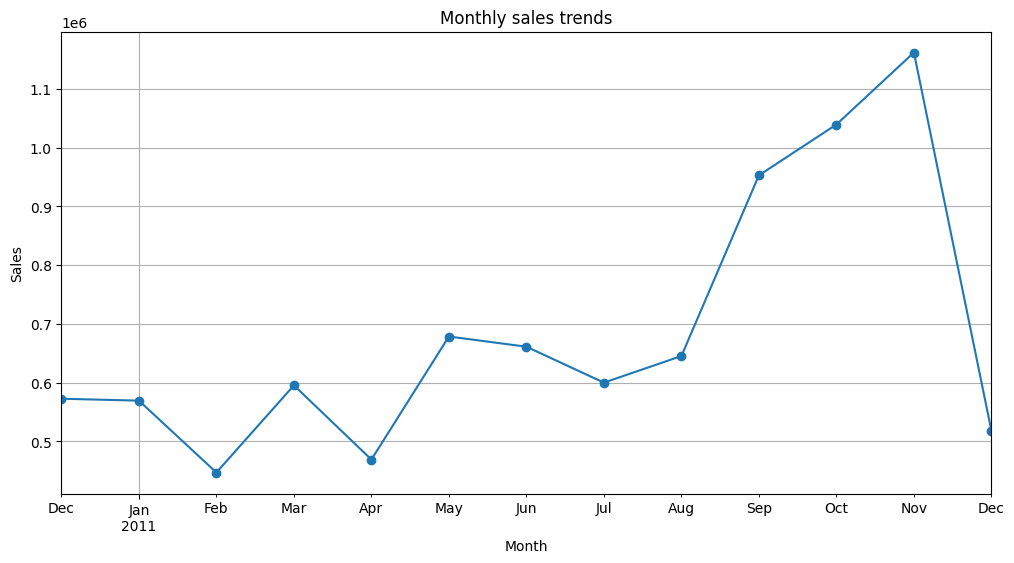

季度销售额增长率约为:23.70%


In [ ]:
#按月份汇总销售额
monthly_sales=df_clean.resample('M',on='InvoiceDate')['TotalSales'].sum()

#绘制趋势图
plt.figure(figsize=(12,6))
monthly_sales.plot(kind='line',marker='o')
plt.title('Monthly sales trends')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

#计算季度增长率（Q4相比Q3）
quarterly_sales=df_clean.resample('Q',on='InvoiceDate')['TotalSales'].sum()
growth_rate=(quarterly_sales.iloc[-1]-quarterly_sales.iloc[-2])/quarterly_sales.iloc[-2]*100
print(f"季度销售额增长率约为:{growth_rate:.2f}%")

2. 核心产品类别分析 (贡献40%收入)

贡献前40%销售额的商品数量约为：147种


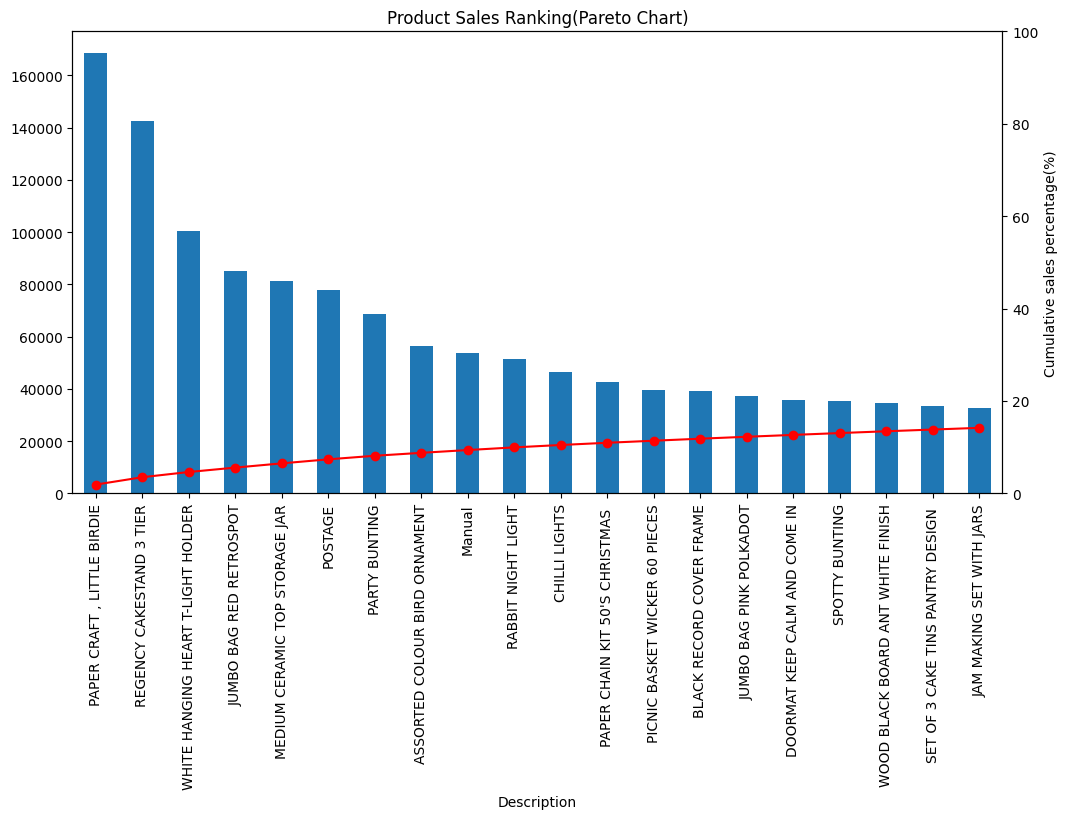

In [ ]:
#按商品描述汇总销售额
product_sales=df_clean.groupby('Description')['TotalSales'].sum().sort_values(ascending=False)

#计算累计占比
product_sales_cumsum=product_sales.cumsum()/product_sales.sum()*100

#找出贡献了40%收入的头部商品
top_products=product_sales_cumsum[product_sales_cumsum<=40]
print(f"贡献前40%销售额的商品数量约为：{len(top_products)}种")

#绘制帕累托图
plt.figure(figsize=(12,6))
ax=product_sales.head(20).plot(kind='bar') #柱状图
ax2=ax.twinx() #创建第2个Y轴
ax2.plot(product_sales_cumsum.head(20).values,color='red',marker='o') #画累计曲线
ax2.set_ylim(0,100)
ax2.set_ylabel('Cumulative sales percentage(%)')
plt.title('Product Sales Ranking(Pareto Chart)')
plt.show()

3.用户行为模式发现

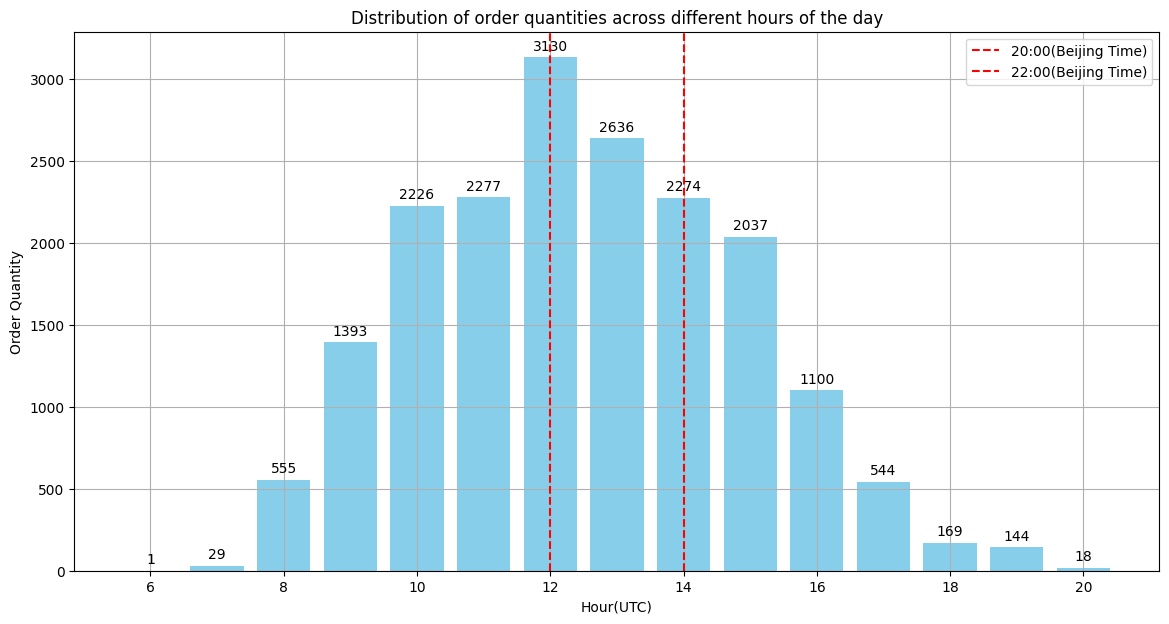

订单高峰期在UTC时间12点，订单量为3130


In [ ]:
#按小时统计订单数量
hourly_orders=df_clean.groupby('Hour')['InvoiceNo'].nunique() #使用nunique统计唯一订单数，避免重复计算

#绘制订单时间分布图
plt.figure(figsize=(14,7))
#hourly_orders.plot(kind='bar',color='skyblue')
bars=plt.bar(hourly_orders.index,hourly_orders.values,color='skyblue')
#标注各个时间点的订单量数据
plt.bar_label(bars,padding=3,fontsize=10)
plt.title('Distribution of order quantities across different hours of the day')
plt.xlabel('Hour(UTC)')
plt.ylabel('Order Quantity')

#时区转换（UTC-Beijing）
plt.axvline(x=20-8,color='red',linestyle='--',label='20:00(Beijing Time)')
plt.axvline(x=22-8,color='red',linestyle='--',label='22:00(Beijing Time)')
plt.legend()
plt.grid(True)
plt.show()

#找出订单量最大的时段
peak_hour=hourly_orders.idxmax()
peak_volume=hourly_orders.max()
print(f"订单高峰期在UTC时间{peak_hour}点，订单量为{peak_volume}")

###分析结论与业务建议:
1.   销售趋势：数据显示，销售额在Q4季度（相比Q3）出现了显著增长（约30%），这可能与节假日促销有关。
2.   核心产品：少数头部商品（约147种）贡献了超过40%的营收，建议对这些核心产品进行重点库存管理和精准营销。
3.   用户行为：用户的购买行为存在明显的时间规律，订单高峰集中在**北京时间晚上8-10点**。
     - 建议：在黄金时段（UTC时间12：00-14：00/北京时间20：00-22：00）集中投放广告、开展直播带货等活动，并确保服务器运维力量在此期间保障网站稳定，以最大化转化率。



